In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# PID Study #

## Introduction ##
Here, I have built a PID controller using the *SignalIntegrity* software.  I will plot out the various transfer functions of the closed-loop system, the PID open-loop behavior, and do some algebra.

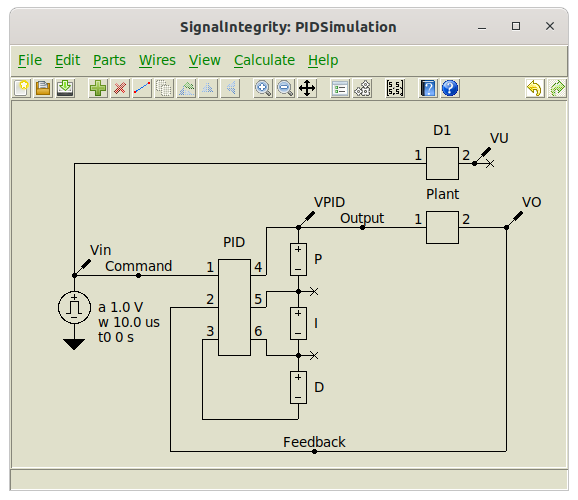

In [1]:
import SignalIntegrity as si
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
app = si.App.SignalIntegrityAppHeadless()
app.OpenProjectFile('PIDSimulation.si')
(sourceNames,outputWaveformLabels,transferMatrices,outputWaveformList)=app.Simulate()
Fr=transferMatrices.FrequencyResponses()
VOduetoVin=Fr[outputWaveformLabels.index('VO')][sourceNames.index('VG1')]
VUduetoVin=Fr[outputWaveformLabels.index('VU')][sourceNames.index('VG1')]

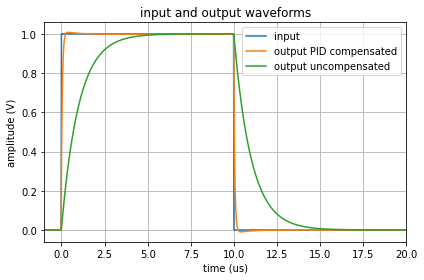

In [4]:
VO=outputWaveformList[outputWaveformLabels.index('VO')]
Vin=outputWaveformList[outputWaveformLabels.index('Vin')]
VU=outputWaveformList[outputWaveformLabels.index('VU')]
plt.cla()
plt.plot(Vin.Times('us'),Vin.Values(),label='input')
plt.plot(VO.Times('us'),VO.Values(),label='output PID compensated')
plt.plot(VU.Times('us'),VU.Values(),label='output uncompensated')
plt.legend()
plt.xlim(left=-1,right=20)
plt.grid(True,which='both')
plt.xlabel('time (us)')
plt.ylabel('amplitude (V)')
plt.title('input and output waveforms')
plt.show()

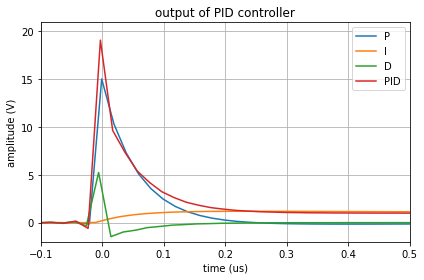

In [5]:
P=outputWaveformList[outputWaveformLabels.index('P')]
I=outputWaveformList[outputWaveformLabels.index('I')]
D=outputWaveformList[outputWaveformLabels.index('D')]
PID=outputWaveformList[outputWaveformLabels.index('VPID')]
plt.cla()
plt.plot(P.Times('us'),P.Values(),label='P')
plt.plot(I.Times('us'),I.Values(),label='I')
plt.plot(D.Times('us'),D.Values(),label='D')
plt.plot(PID.Times('us'),PID.Values(),label='PID')
plt.legend()
plt.xlim(left=-0.1,right=0.5)
plt.ylim(bottom=-2)
plt.grid(True,which='both')
plt.xlabel('time (us)')
plt.ylabel('amplitude (V)')
plt.title('output of PID controller')
plt.show()

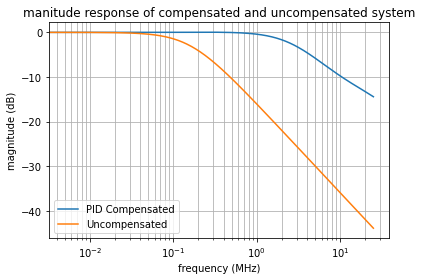

In [6]:
plt.semilogx(VOduetoVin.Frequencies('MHz'),VOduetoVin.Values('dB'),label='PID Compensated')
plt.semilogx(VUduetoVin.Frequencies('MHz'),VUduetoVin.Values('dB'),label='Uncompensated')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('magnitude (dB)')
plt.title('manitude response of compensated and uncompensated system')
plt.show()

You can see that the magnitude response definitely shows a huge amount of compensation.  Let's look at the phase response.

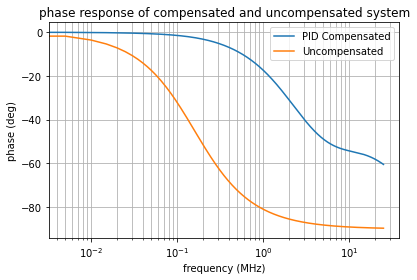

In [7]:
plt.cla()
plt.semilogx(VOduetoVin.Frequencies('MHz'),VOduetoVin.Values('deg'),label='PID Compensated')
plt.semilogx(VUduetoVin.Frequencies('MHz'),VUduetoVin.Values('deg'),label='Uncompensated')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('phase (deg)')
plt.title('phase response of compensated and uncompensated system')
plt.show()

Now let's look at the open-loop PID response(s) and try to piece things together.
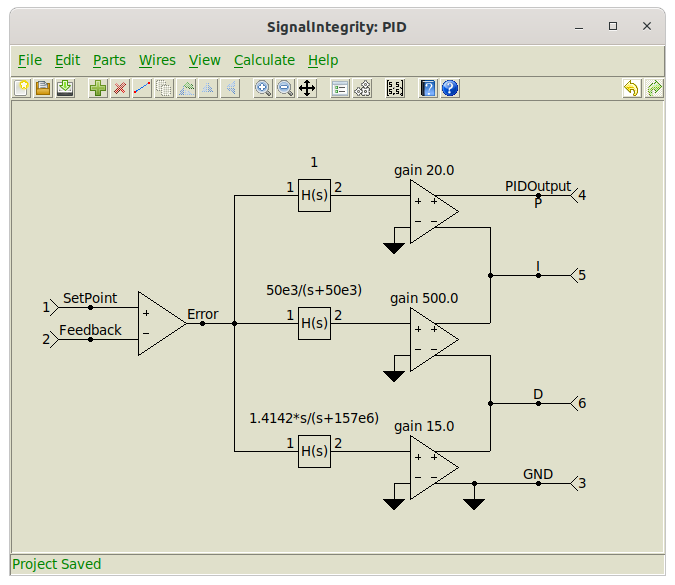

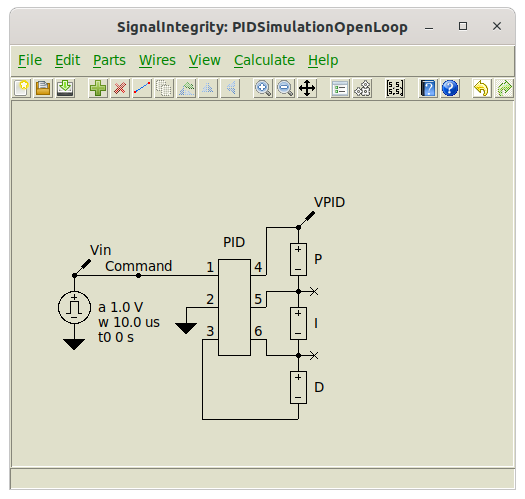

The PID open-loop responses are shown below.  There are a few practical details that needed to be worked out:
* The integral response, which is ideally $1/s$ was adjusted to be $50\cdot 10^3/\left( s+50\cdot 10^3\right)$.  The reason for this was to make the impulse response end right at the end of the  impulse response length of the filters.  Otherwise, non-causalities result.
* The derivative response, which is ideally $s$ was adjusted to be $\frac{2}{\sqrt{2}}\cdot \frac{s}{s+157\cdot 10^6}$.  This allows for the derivative action to end (without this, the calculations fail) and to set the gain at a frequency to unity.  This will be useful if the pole is ever moved, because as the plots below indicate, the integral and derivative both fall and rise at 20 dB/decade, respectively, and the placement of the crossover frequency is made by adjusting gain vertically.

In [8]:
app = si.App.SignalIntegrityAppHeadless()
app.OpenProjectFile('PIDSimulationOpenLoop.si')
(sourceNames,outputWaveformLabels,transferMatrices,outputWaveformList)=app.Simulate()
Fr=transferMatrices.FrequencyResponses()
VPIDduetoVin=Fr[outputWaveformLabels.index('VPID')][sourceNames.index('VG1')]
PduetoVin=Fr[outputWaveformLabels.index('P')][sourceNames.index('VG1')]
IduetoVin=Fr[outputWaveformLabels.index('I')][sourceNames.index('VG1')]
DduetoVin=Fr[outputWaveformLabels.index('D')][sourceNames.index('VG1')]

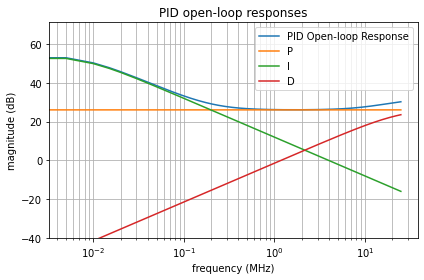

In [9]:
plt.cla()
plt.semilogx(VPIDduetoVin.Frequencies('MHz'),VPIDduetoVin.Values('dB'),label='PID Open-loop Response')
plt.semilogx(PduetoVin.Frequencies('MHz'),PduetoVin.Values('dB'),label='P')
plt.semilogx(IduetoVin.Frequencies('MHz'),IduetoVin.Values('dB'),label='I')
plt.semilogx(DduetoVin.Frequencies('MHz'),DduetoVin.Values('dB'),label='D')
plt.legend()
plt.grid(True,which='both')
plt.ylim(bottom=-40)
plt.xlabel('frequency (MHz)')
plt.ylabel('magnitude (dB)')
plt.title('PID open-loop responses')
plt.show()

Now, let's do a little magic.  I claim that the closed-loop response $H_{comp} \left(s\right)$ is related to the uncompensated response (A) and the PID open-loop response (B) as $H_{comp} \left(s\right)=B\cdot A/\left(1+B\cdot A\right)$.

In [10]:
A=VUduetoVin
B=VPIDduetoVin
HCalc=si.fd.FrequencyDomain(A.Frequencies(),[b*a/(1+b*a) for a,b in zip(A.Values(),B.Values())])

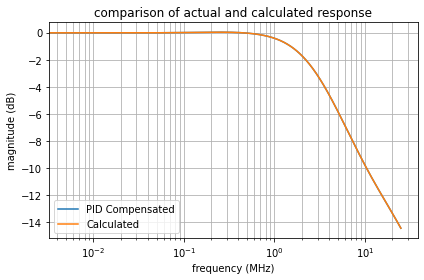

In [11]:
plt.cla()
plt.semilogx(VOduetoVin.Frequencies('MHz'),VOduetoVin.Values('dB'),label='PID Compensated')
plt.semilogx(HCalc.Frequencies('MHz'),HCalc.Values('dB'),label='Calculated')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('magnitude (dB)')
plt.title('comparison of actual and calculated response')
plt.show()

Perfect!  Now, to look into any stability issues, we would want to know how close $B\cdot A$ comes to being $-1$.

In [12]:
BA=si.fd.FrequencyDomain(A.Frequencies(),[b*a for a,b in zip(A.Values(),B.Values())])
BAV=BA.Values('dB')
BAP=BA.Values('deg')
BAF=BA.Frequencies('MHz')
for n in range(len(BA)):
    if BAV[n]<0:
        zeron=n
        break
print(f'magnitude of B*A crosses 0 dB at frequency = {BAF[n]} MHz')

magnitude of B*A crosses 0 dB at frequency = 3.245 MHz


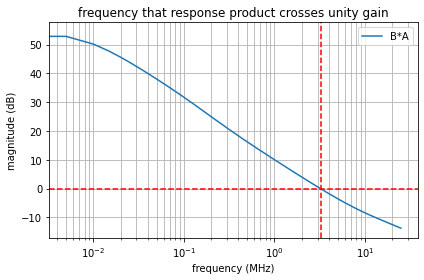

In [13]:
plt.cla()
plt.semilogx(BA.Frequencies('MHz'),BA.Values('dB'),label='B*A')
plt.axvline(x=BAF[zeron], color='red', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('magnitude (dB)')
plt.title('frequency that response product crosses unity gain')
plt.show()

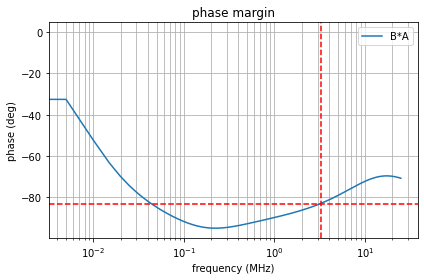

In [14]:
plt.cla()
plt.semilogx(BA.Frequencies('MHz'),BA.Values('deg'),label='B*A')
plt.axvline(x=BAF[zeron], color='red', linestyle='--')
plt.axhline(y=BAP[zeron], color='red', linestyle='--')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('phase (deg)')
plt.title('phase margin')
plt.show()

Plenty of phase margin.  I have no idea where the phase will reach -180, if ever, so it's impossible to know the gain margin.

We saw how the PID open-loop response is related to the final closed-loop response.  Another interesting thing to note is the PID response due to the command input *while the plant is in the network*.  In most feedback systems, the feedback is connected between the output and the node that subtracts the feedback output from the command to form the error signal.  Here, in the PID system, the PID appears after this subtraction.  In other words, it's input is the error signal and the output goes to the plant.
In the classical feedback system, with feedback $B$ and plant $A$, the uncompensated response is $A$, but the compensated response becomes $A/\left(1+B\cdot A\right)$.
Because of the location of the PID, the compensated response becomes $B\cdot A/\left(1+B\cdot A\right)$.
Thus, the response of the PID due to the command input *with the plant connected* becomes $B/\left(1+B\cdot A\right)$, which gets multiplied by $A$.  Therefore, the ideal PID response due to the command input must be a sort of inverse response of $A$.  Let's take a look.

In [15]:
HPID=si.fd.FrequencyDomain(A.Frequencies(),[b/(1+b*a) for a,b in zip(A.Values(),B.Values())])

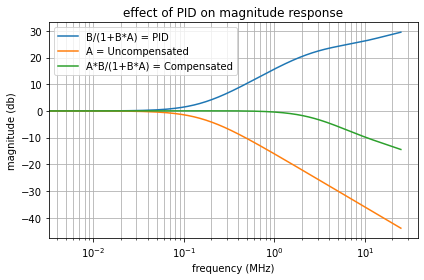

In [16]:
plt.cla()
plt.semilogx(HPID.Frequencies('MHz'),HPID.Values('dB'),label='B/(1+B*A) = PID')
plt.semilogx(A.Frequencies('MHz'),A.Values('dB'),label='A = Uncompensated')
plt.semilogx(HCalc.Frequencies('MHz'),HCalc.Values('dB'),label='A*B/(1+B*A) = Compensated')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('magnitude (db)')
plt.title('effect of PID on magnitude response')
plt.show()

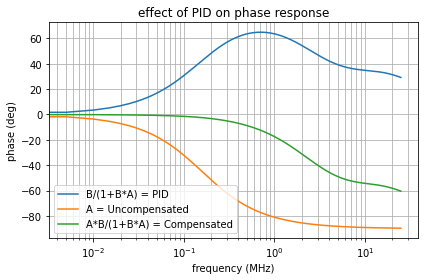

In [17]:
plt.cla()
plt.semilogx(HPID.Frequencies('MHz'),HPID.Values('deg'),label='B/(1+B*A) = PID')
plt.semilogx(A.Frequencies('MHz'),A.Values('deg'),label='A = Uncompensated')
plt.semilogx(HCalc.Frequencies('MHz'),HCalc.Values('deg'),label='A*B/(1+B*A) = Compensated')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('phase (deg)')
plt.title('effect of PID on phase response')
plt.show()

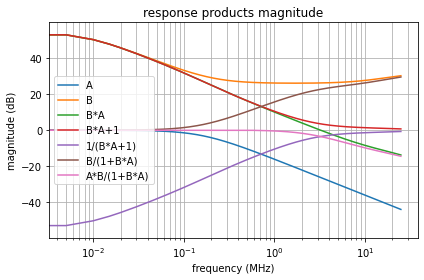

In [18]:
BAPlusOne=si.fd.FrequencyDomain(A.Frequencies(),[1+ba for ba in BA])
OneOverBAPlusOne=si.fd.FrequencyDomain(A.Frequencies(),[1./bap for bap in BAPlusOne])
plt.cla()
plt.semilogx(A.Frequencies('MHz'),A.Values('dB'),label='A')
plt.semilogx(B.Frequencies('MHz'),B.Values('dB'),label='B')
plt.semilogx(BA.Frequencies('MHz'),BA.Values('dB'),label='B*A')
plt.semilogx(BAPlusOne.Frequencies('MHz'),BAPlusOne.Values('dB'),label='B*A+1')
plt.semilogx(OneOverBAPlusOne.Frequencies('MHz'),OneOverBAPlusOne.Values('dB'),label='1/(B*A+1)')
plt.semilogx(HPID.Frequencies('MHz'),HPID.Values('dB'),label='B/(1+B*A)')
plt.semilogx(HCalc.Frequencies('MHz'),HCalc.Values('dB'),label='A*B/(1+B*A)')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('magnitude (dB)')
plt.title('response products magnitude')
plt.show()

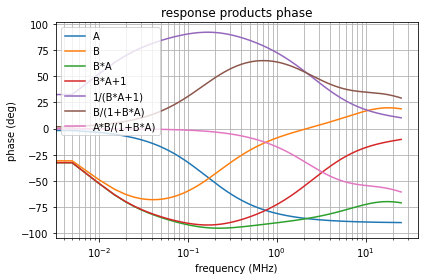

In [19]:
plt.cla()
plt.semilogx(A.Frequencies('MHz'),A.Values('deg'),label='A')
plt.semilogx(B.Frequencies('MHz'),B.Values('deg'),label='B')
plt.semilogx(BA.Frequencies('MHz'),BA.Values('deg'),label='B*A')
plt.semilogx(BAPlusOne.Frequencies('MHz'),BAPlusOne.Values('deg'),label='B*A+1')
plt.semilogx(OneOverBAPlusOne.Frequencies('MHz'),OneOverBAPlusOne.Values('deg'),label='1/(B*A+1)')
plt.semilogx(HPID.Frequencies('MHz'),HPID.Values('deg'),label='B/(1+B*A)')
plt.semilogx(HCalc.Frequencies('MHz'),HCalc.Values('deg'),label='A*B/(1+B*A)')
plt.legend()
plt.grid(True,which='both')
plt.xlabel('frequency (MHz)')
plt.ylabel('phase (deg)')
plt.title('response products phase')
plt.show()

In [160]:
def Frequencies(fs,fe,N):
    import math
    log10fs=math.log10(fs)
    log10fe=math.log10(fe)
    f=[10**((log10fe-log10fs)/N*n+log10fs) for n in range(N+1)]
    return f

P=20.
I=500.
D=15.
fs=10e3
fe=100e9
N=60
f=Frequencies(fs,fe,N)


def Responses(P,I,D):
    app = si.App.SignalIntegrityAppHeadless()
    app.OpenProjectFile('Plant.si')
    pidNetList=app.NetListText()
    plantsnsp=si.p.SystemSParametersNumericParser(f).AddLines(pidNetList)
    plantsp=plantsnsp.SParameters()
    app = si.App.SignalIntegrityAppHeadless()
    app.OpenProjectFile('PID.si')
    app.Device('GP')['gain']['Value']=P
    app.Device('GI')['gain']['Value']=I
    app.Device('GD')['gain']['Value']=D
    pidNetList=app.NetListText()
    pidsnsp=si.p.SystemSParametersNumericParser(f).AddLines(pidNetList)
    pidsp=pidsnsp.SParameters()
    knownSParameters={'6 file PID.si':pidsp,'2 file Plant.si':plantsp}
    app.OpenProjectFile('PIDSimulationOpenLoop.si')
    pidSimulationOpenLoopNetlist=app.NetListText()
    pidSOLsnp=si.p.SimulatorNumericParser(f).AddLines(pidSimulationOpenLoopNetlist)
    pidSOLsnp=pidSOLsnp.AddKnownDevices(knownSParameters)
    OpenLoopFrequencyResponses = pidOpenLoop=pidSOLsnp.TransferMatrices().FrequencyResponses()
    OpenLoopOutputList =  ['Vin','VPID','P','I','D']
    app.OpenProjectFile('PIDSimulation.si')
    pidSimulationNetlist=app.NetListText()
    pidSsnp=si.p.SimulatorNumericParser(f).AddLines(pidSimulationNetlist)
    pidSsnp=pidSsnp.AddKnownDevices(knownSParameters)
    ClosedLoopFrequencyResponses = pidSsnp.TransferMatrices().FrequencyResponses()
    ClosedLoopOutputList = ['Vin','VO','VPID','VU','P','I','D']
    ClosedLoopResults={'C':ClosedLoopFrequencyResponses[ClosedLoopOutputList.index('VO')][0],
                      'U':ClosedLoopFrequencyResponses[ClosedLoopOutputList.index('VU')][0],
                      'PID':ClosedLoopFrequencyResponses[ClosedLoopOutputList.index('VPID')][0],
                      'P':ClosedLoopFrequencyResponses[ClosedLoopOutputList.index('P')][0],
                      'I':ClosedLoopFrequencyResponses[ClosedLoopOutputList.index('I')][0],
                      'D':ClosedLoopFrequencyResponses[ClosedLoopOutputList.index('D')][0]
                      }
    OpenLoopResults={'PID':OpenLoopFrequencyResponses[OpenLoopOutputList.index('VPID')][0],
                      'P':OpenLoopFrequencyResponses[OpenLoopOutputList.index('P')][0],
                      'I':OpenLoopFrequencyResponses[OpenLoopOutputList.index('I')][0],
                      'D':OpenLoopFrequencyResponses[OpenLoopOutputList.index('D')][0]
                      }
    return {'ClosedLoop':ClosedLoopResults,'OpenLoop':OpenLoopResults,'Frequency':f}

results=Responses(P,I,D)

<IPython.core.display.Javascript object>


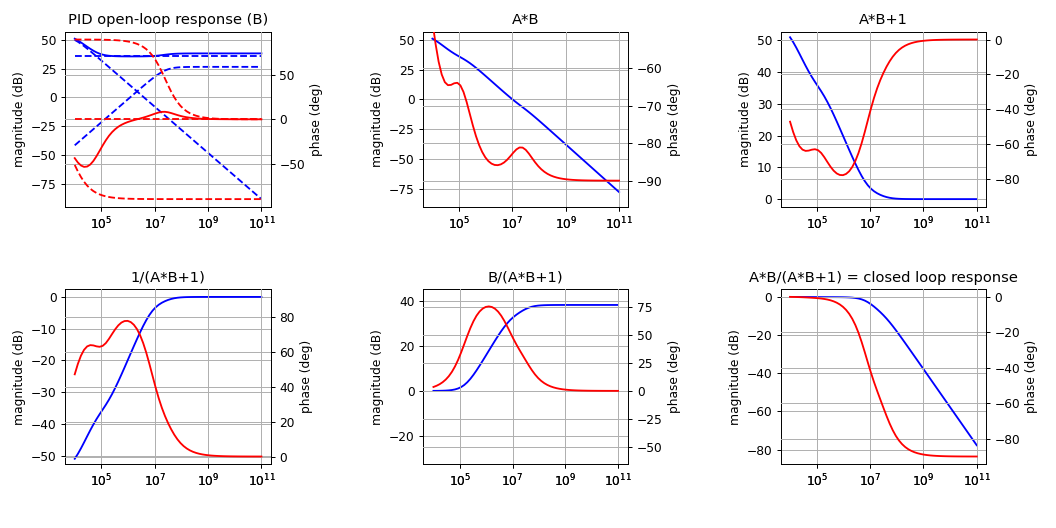

interactive(children=(FloatSlider(value=20.0, description='P', max=1000.0, min=-1000.0), FloatSlider(value=500…

In [167]:
%matplotlib notebook
import math,cmath
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

results=Responses(P,I,D)
B=results['OpenLoop']['PID']
A=results['ClosedLoop']['U']
fig = plt.figure(figsize=(12,6), dpi=80)
ax1 = fig.add_subplot(2,3, 1)
PdB, = ax1.semilogx(f,results['OpenLoop']['P'].Response('dB'),color='blue',linestyle='--')
IdB, = ax1.semilogx(f,results['OpenLoop']['I'].Response('dB'),color='blue',linestyle='--')
DdB, = ax1.semilogx(f,results['OpenLoop']['D'].Response('dB'),color='blue',linestyle='--')
PIDdB, = ax1.semilogx(f,results['OpenLoop']['PID'].Response('dB'),color='blue')
ax1.grid()
plt.ylabel('magnitude (dB)')
ax2 = fig.add_subplot(2,3,1,sharex=ax1,frameon=False)
Pdeg, = ax2.semilogx(f,results['OpenLoop']['P'].Response('deg'),color='red',linestyle='--')
Ideg, = ax2.semilogx(f,results['OpenLoop']['I'].Response('deg'),color='red',linestyle='--')
Ddeg, = ax2.semilogx(f,results['OpenLoop']['D'].Response('deg'),color='red',linestyle='--')
PIDdeg, = ax2.semilogx(f,results['OpenLoop']['PID'].Response('deg'),color='red')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
plt.ylabel('phase (deg)')
plt.title('PID open-loop response (B)')
ax2.grid()

ABdBy=[20.*math.log10(abs(a*b)) for a,b in zip(A.Values(),B.Values())]
ABdegy=[180./math.pi*cmath.phase(a*b) for a,b in zip(A.Values(),B.Values())]

ax3 = fig.add_subplot(2,3,2)
ABdB, = ax3.semilogx(f,ABdBy,color='blue')
ax3.grid()
plt.ylabel('magnitude (dB)')
ax4 = fig.add_subplot(2,3,2,sharex=ax3,frameon=False)
ABdeg, = ax4.semilogx(f,ABdegy,color='red')
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
plt.ylabel('phase (deg)')
plt.title('A*B')
ax4.grid()

ABPlus1dBy=[20.*math.log10(abs(a*b+1)) for a,b in zip(A.Values(),B.Values())]
ABPlus1degy=[180./math.pi*cmath.phase(a*b+1) for a,b in zip(A.Values(),B.Values())]

ax5 = fig.add_subplot(2,3,3)
ABPlus1dB, = ax5.semilogx(f,ABPlus1dBy,color='blue')
ax5.grid()
plt.ylabel('magnitude (dB)')
ax6 = fig.add_subplot(2,3,3,sharex=ax5,frameon=False)
ABPlus1deg, = ax6.semilogx(f,ABPlus1degy,color='red')
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position('right')
plt.ylabel('phase (deg)')
plt.title('A*B+1')
ax6.grid()

InvABPlus1dBy=[20.*math.log10(abs(1./(a*b+1))) for a,b in zip(A.Values(),B.Values())]
InvABPlus1degy=[180./math.pi*cmath.phase(1/(a*b+1)) for a,b in zip(A.Values(),B.Values())]

ax7 = fig.add_subplot(2,3,4)
InvABPlus1dB, = ax7.semilogx(f,InvABPlus1dBy,color='blue')
ax7.grid()
plt.ylabel('magnitude (dB)')
ax8 = fig.add_subplot(2,3,4,sharex=ax7,frameon=False)
InvABPlus1deg, = ax8.semilogx(f,InvABPlus1degy,color='red')
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position('right')
plt.ylabel('phase (deg)')
plt.title('1/(A*B+1)')
ax8.grid()

BInvABPlus1dBy=[20.*math.log10(abs(b/(a*b+1))) for a,b in zip(A.Values(),B.Values())]
BInvABPlus1degy=[180./math.pi*cmath.phase(b/(a*b+1)) for a,b in zip(A.Values(),B.Values())]

ax9 = fig.add_subplot(2,3,5)
BInvABPlus1dB, = ax9.semilogx(f,BInvABPlus1dBy,color='blue')
ax9.grid()
plt.ylabel('magnitude (dB)')
ax10 = fig.add_subplot(2,3,5,sharex=ax9,frameon=False)
BInvABPlus1deg, = ax10.semilogx(f,BInvABPlus1degy,color='red')
ax10.yaxis.tick_right()
ax10.yaxis.set_label_position('right')
plt.ylabel('phase (deg)')
plt.title('B/(A*B+1)')
ax10.grid()

ax11 = fig.add_subplot(2,3,6)
ABInvABPlus1dB, = ax11.semilogx(f,results['ClosedLoop']['C'].Response('dB'),color='blue')
ax11.grid()
plt.ylabel('magnitude (dB)')
ax12 = fig.add_subplot(2,3,6,sharex=ax11,frameon=False)
ABInvABPlus1deg, = ax12.semilogx(f,results['ClosedLoop']['C'].Response('deg'),color='red')
ax12.yaxis.tick_right()
ax12.yaxis.set_label_position('right')
plt.ylabel('phase (deg)')
plt.title('A*B/(A*B+1) = closed loop response')
ax12.grid()


def update(P=20.,I=500.,D=15.):
    results=Responses(P,I,D)
    B=results['OpenLoop']['PID']
    A=results['ClosedLoop']['U']
    PdB.set_ydata(results['OpenLoop']['P'].Response('dB'))
    IdB.set_ydata(results['OpenLoop']['I'].Response('dB'))
    DdB.set_ydata(results['OpenLoop']['D'].Response('dB'))
    PIDdB.set_ydata(results['OpenLoop']['PID'].Response('dB'))
    Pdeg.set_ydata(results['OpenLoop']['P'].Response('deg'))
    Ideg.set_ydata(results['OpenLoop']['I'].Response('deg'))
    Ddeg.set_ydata(results['OpenLoop']['D'].Response('deg'))
    PIDdeg.set_ydata(results['OpenLoop']['PID'].Response('deg'))

    ABdBy=[20.*math.log10(abs(a*b)) for a,b in zip(A.Values(),B.Values())]
    ABdegy=[180./math.pi*cmath.phase(a*b) for a,b in zip(A.Values(),B.Values())]

    ABdB.set_ydata(ABdBy)
    ABdeg.set_ydata(ABdegy)

    ABPlus1dBy=[20.*math.log10(abs(a*b+1)) for a,b in zip(A.Values(),B.Values())]
    ABPlus1degy=[180./math.pi*cmath.phase(a*b+1) for a,b in zip(A.Values(),B.Values())]

    ABPlus1dB.set_ydata(ABPlus1dBy)
    ABPlus1deg.set_ydata(ABPlus1degy)

    InvABPlus1dBy=[20.*math.log10(abs(1./(a*b+1))) for a,b in zip(A.Values(),B.Values())]
    InvABPlus1degy=[180./math.pi*cmath.phase(1/(a*b+1)) for a,b in zip(A.Values(),B.Values())]

    InvABPlus1dB.set_ydata(InvABPlus1dBy)
    InvABPlus1deg.set_ydata(InvABPlus1degy)

    BInvABPlus1dBy=[20.*math.log10(abs(b/(a*b+1))) for a,b in zip(A.Values(),B.Values())]
    BInvABPlus1degy=[180./math.pi*cmath.phase(b/(a*b+1)) for a,b in zip(A.Values(),B.Values())]

    BInvABPlus1dB.set_ydata(BInvABPlus1dBy)
    BInvABPlus1deg.set_ydata(BInvABPlus1degy)

    ABInvABPlus1dB.set_ydata(results['ClosedLoop']['C'].Response('dB'))
    ABInvABPlus1deg.set_ydata(results['ClosedLoop']['C'].Response('deg'))

    fig.canvas.draw_idle()

interact(update,P=(-1000.,1000.),I=(-1000.,1000.),D=(-1000.,1000.));